In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

import sklearn.metrics as skm

import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [2]:
# import dataset
data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

# extract labels(number IdS) remove from data
labels = data[:,0]
data = data[:,1:]

# normalize the data to a range  of [0 1]
dataNorm = data /np.max(data)


# Remove most of the 7's from the data

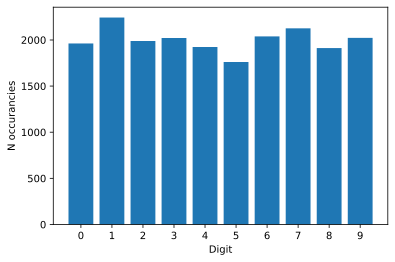

In [3]:
# equal number of elements in each category
# category counts

catcounts  = np.unique(labels,return_counts=True)

# vicualize
plt.bar(catcounts[0],catcounts[1])
plt.xlabel('Digit')
plt.ylabel('N occurancies')
plt.xticks(range(10))
plt.show()

In [6]:
# find all the 7's
where7s = np.where(labels==7)[0]

# to leave 500   7's from the data
N2remove = where7s.shape[0] - 500

# pick that number of 7's at random
remove7s = np.random.choice(where7s,size=N2remove,replace=False)

# and remove that from the dataa
print('Sizes before removing')
print(dataNorm.shape)
print(labels.shape)

dataNorm = np.delete(dataNorm,remove7s,axis=0)
labels = np.delete(labels,remove7s)

print('\n\nsizes after removing')
print(dataNorm.shape)
print(labels.shape)


Sizes before removing
(20000, 784)
(20000,)


sizes after removing
(18374, 784)
(18374,)


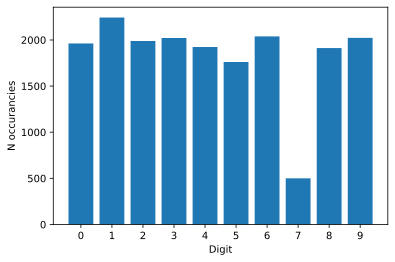

In [7]:
# visual confirmation of our manipulation
catcounts = np.unique(labels,return_counts=True)
plt.bar(catcounts[0],catcounts[1])
plt.xlabel('Digit')
plt.ylabel('N occurancies')
plt.xticks(range(10))
plt.show()

In [8]:
# moving right
# convert to tensor
dataT = torch.tensor(dataNorm).float()
labelsT = torch.tensor(labels).long()

# use scikit-learn to split the data
train_data,test_data,train_labels,test_labels = train_test_split(dataT,labelsT,test_size=.1)

# convert into pytorch datasets
train_data = torch.utils.data.TensorDataset(train_data,train_labels)
test_data = torch.utils.data.TensorDataset(test_data,test_labels)

# translate into dataloader objects
batchsize = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [12]:
# DL model

def createTheMNISTNet():
    class mnistNet(nn.Module):
        def __init__(self):
            super().__init__()

            #input layer
            self.input = nn.Linear(784,64)

            # hidden layer
            self.fc1 = nn.Linear(64,32)
            self.fc2 = nn.Linear(32,32)

            #output layer
            self.output = nn.Linear(32,10)

        # forward pass
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            return self.output(x)

    # create the model instance
    net = mnistNet()
    #loss function
    lossfun = nn.CrossEntropyLoss()

    #optimizer
    optimizer = torch.optim.Adam(net.parameters(),lr=.01)
    
    return net,lossfun,optimizer

In [13]:
def funtion2trainTheModel():

  # number of epochs
  numepochs = 10
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [14]:
trainAcc,testAcc,losses,net = funtion2trainTheModel()

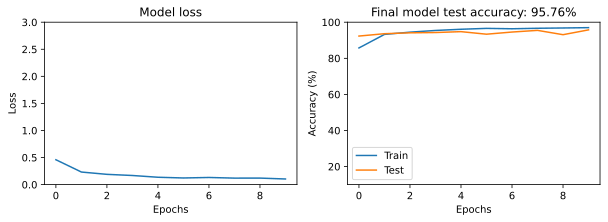

In [15]:
fig,ax = plt.subplots(1,2,figsize=(10,3))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

# Compute the performance measure on the train and test data

In [16]:
# predicted digits for training data
yHat = net(train_loader.dataset.tensors[0])
train_predictions = torch.argmax(yHat,axis=1)

# predictions for test data
yHat = net(test_loader.dataset.tensors[0])
test_predictions = torch.argmax(yHat,axis=1)
test_predictions


tensor([3, 1, 8,  ..., 9, 5, 6])

In [17]:
# initialize vectors
train_metrics = [0,0,0,0]
test_metrics  = [0,0,0,0]

# training
train_metrics[0] = skm.accuracy_score (train_loader.dataset.tensors[1],train_predictions) # accuracy is overall
train_metrics[1] = skm.precision_score(train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[2] = skm.recall_score   (train_loader.dataset.tensors[1],train_predictions,average='weighted')
train_metrics[3] = skm.f1_score       (train_loader.dataset.tensors[1],train_predictions,average='weighted')


# test
test_metrics[0] = skm.accuracy_score (test_loader.dataset.tensors[1],test_predictions)
test_metrics[1] = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[2] = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average='weighted')
test_metrics[3] = skm.f1_score       (test_loader.dataset.tensors[1],test_predictions,average='weighted')

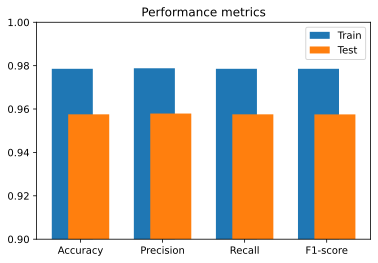

In [18]:
plt.bar(np.arange(4)-.1,train_metrics,.5)
plt.bar(np.arange(4)+.1,test_metrics,.5)
plt.xticks([0,1,2,3],['Accuracy','Precision','Recall','F1-score'])
plt.ylim([.9,1])
plt.legend(['Train','Test'])
plt.title('Performance metrics')
plt.show()

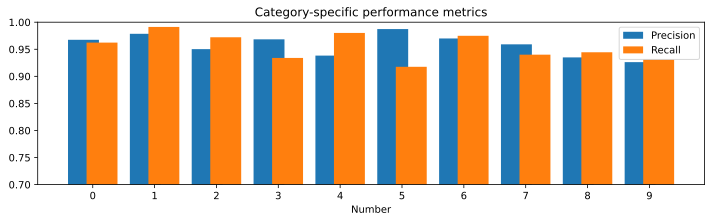

In [19]:
# Bar graphs of class-specific precision and recall for test data

precision = skm.precision_score(test_loader.dataset.tensors[1],test_predictions,average=None)
recall    = skm.recall_score   (test_loader.dataset.tensors[1],test_predictions,average=None)


fig = plt.figure(figsize=(12,3))
plt.bar(np.arange(10)-.15,precision,.5)
plt.bar(np.arange(10)+.15,recall,.5)
plt.xticks(range(10),range(10))
plt.ylim([.7,1])
plt.xlabel('Number')
plt.legend(['Precision','Recall'])
plt.title('Category-specific performance metrics')
plt.show()

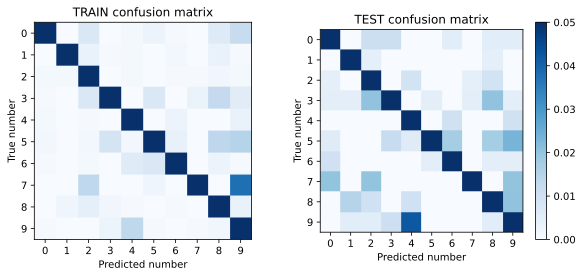

In [20]:
# Confusion matrices
trainConf = skm.confusion_matrix(train_loader.dataset.tensors[1],train_predictions,normalize='true')
testConf  = skm.confusion_matrix(test_loader.dataset.tensors[1], test_predictions,normalize='true')

fig,ax = plt.subplots(1,2,figsize=(10,4))

# confmat during TRAIN
ax[0].imshow(trainConf,'Blues',vmax=.05)
ax[0].set_xticks(range(10))
ax[0].set_yticks(range(10))
ax[0].set_title('TRAIN confusion matrix')
ax[0].set_xlabel('True number')
ax[0].set_xlabel('Predicted number')
ax[0].set_ylabel('True number')

# confmat during TEST
a = ax[1].imshow(testConf,cmap='Blues',vmax=.05)
ax[1].set_xticks(range(10))
ax[1].set_yticks(range(10))
ax[1].set_title('TEST confusion matrix')
ax[1].set_xlabel('Predicted number')
ax[1].set_ylabel('True number')

fig.colorbar(a)
plt.show()